## GMM

### Importing basic libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import MCMC_DZ.MCMC.Visualization_tools as Vts
import MCMC_DZ.MCMC.Statistic_tools as Sts
from MCMC_DZ.MCMC.MetropolisHastingMCMC.MHMC import MHMC
import MCMC_DZ.MCMC.MetropolisHastingMCMC.ProposalDistributions as PDs
from MCMC_DZ.BayesianInference.Likelihood_functions import GMM

### The pdf function

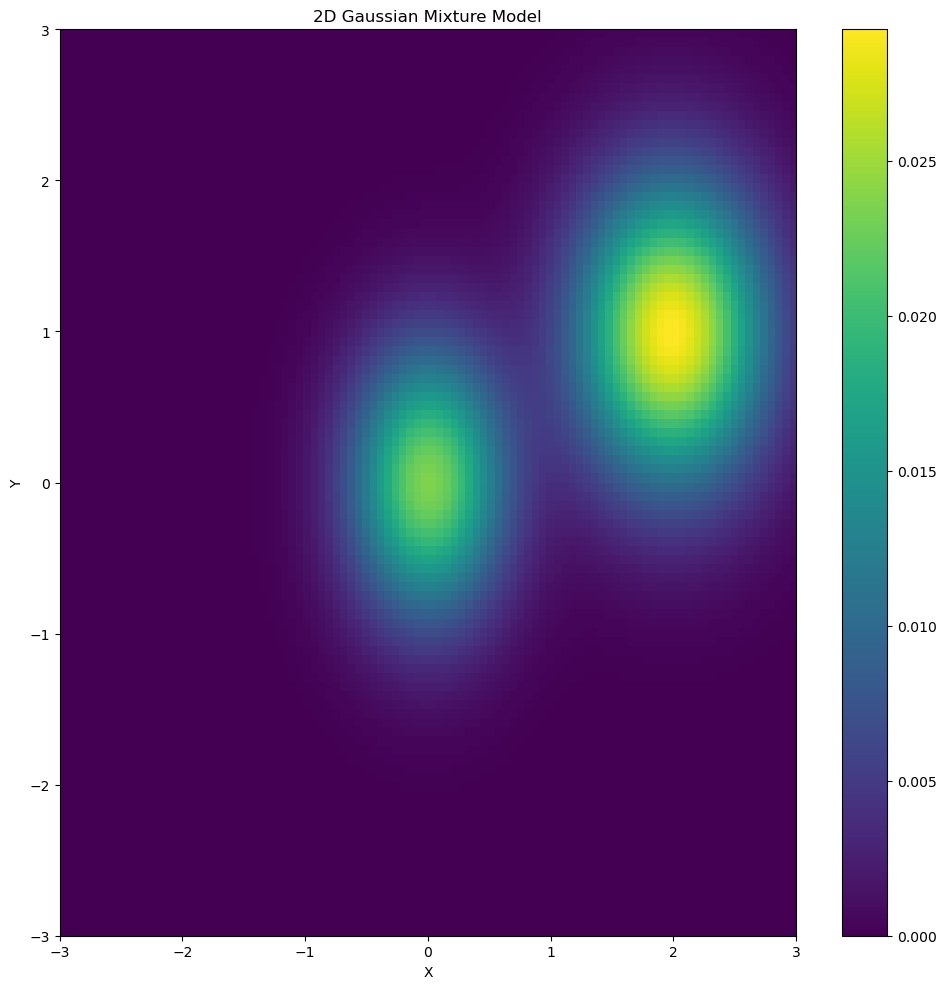

In [25]:
Data_range = np.array([[-3, 3], [-3, 3]])
Sigma =  np.asarray([[[0.2, 0], [0, 0.4]], [[0.3, 0], [0, 0.5]]])
pdf = GMM.Gaussian_Mixture_Model(params=np.asarray([0.2, 0.1, 0, 0, 2, 1]), Sigmas=Sigma)
Vts.Target_Distribution_Visualization(X_range=Data_range[0], Y_range=Data_range[1], Tar_Dis=pdf.f, Func_name="2D Gaussian Mixture Model", alpha=1)

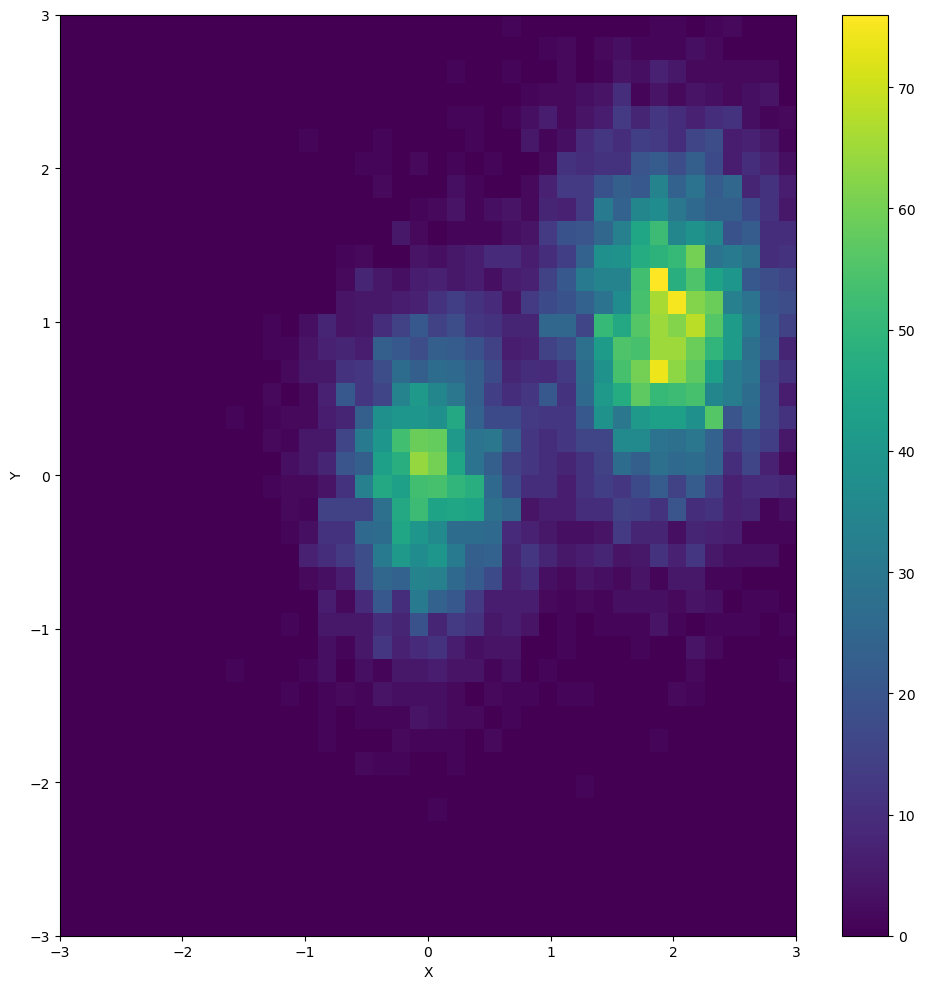

In [5]:
FD = Sts.FakeDataGen2D_Poisson(pdf.f, Data_range, 40, scaler=100000)


Vts.PlotHeatmap(FD.x , FD.y, FD.BinsValue.reshape(FD.x.shape), xlabel="X", ylabel="Y", zlabel="F(X,Y)")

In [6]:
L_Gen = Sts.LikeliFuncGen_ContinuousPoisson(FD, pdf)

## Metropolis-Hasting MCMC

### Initializing the list to collect the outputs of the MCMC algorithm

In [9]:
Res = []

In [8]:
# Loading the pre outputs
data_folder = "Datas/Data_40bins_100000scale_GMM/"
for name in os.listdir(data_folder):
    data_dir = os.path.join(data_folder, name)
    Res.append(Sts.Loading_Data(data_dir))

### Applying MCMC algorithm on the likelihood funciton

In [11]:
steps = 1000000

In [22]:
sd = [0.01, 0.01, 0.005, 0.005, 0.005, 0.005]
Prop_G = PDs.GaussianProposalDistribution(sd=sd, Dim=6)
MHMC_SF = MHMC(rho=L_Gen.Log_Likelihood, log_likelihood=True)
Res_G = MHMC_SF.generate(
    theta0=[0 for _ in range(6)], 
    ProposalFunction=Prop_G,
    steps=steps,
    OutputRunTime=100,
    MaxTime=1200
)
Res.append(Res_G)

In [26]:
for k in range(len(Res)):
    sd = Res[k]["PD_sd"]
    Saving_dir = f"Datas/Data_40bins_100000scale_GMM/Res_G(sd={sd}).npz"
    Sts.Saving_Data(Res[k], FileName=Saving_dir)

In [15]:
# for Res_G_SF in Res:
#     sd = Res_G_SF["PD_sd"]
#     Vts.density_plot(
#         Res_G_SF["Thetas"][:1000000], 
#         bins=50,
#         burn_in=10000,
#         credible_region=0,
#         x_name="B",
#         y_name="C",
#         label = f" with sd = {sd}",
#         alpha=1,
#     )

In [16]:
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

def density_plots(Thetas, plot_axis, bins, burn_in, axis_name=[], cr_1D=0, cr_2D=0, figsize=(12, 9), cmap='viridis', information="", Saving_address=""):
    """
    Plot the density of each axis and the heat map of each pair of axis    

    Arguments
    ---------
    Thetas (np.array): the value of parameters generated by the MCMC model
    plot_axis (List[int]): the axis plotted by the function
    bins (int): the number of bins of each histogram and heat map
    burn_in (int): the number of the data points want to "burn_in" for the graph
    cr_1D (float): the credible region of each 1D density histogram
    figsize: the figure size of the plots
    cmap: the color map used for the 2D histogram
    information (str): information to be displayed on the right corner of the plot

    Returns
    -------
    None
    """

    if not(plot_axis):
        plot_axis = [i for i in range(Thetas.shape[1])]
    n_axis = len(plot_axis)
    datasize = Thetas.shape[0]
    CR_1D = {}
    max_density_1D_info = "\nmax_desnity_value"

    with plt.style.context("ggplot"):

        fig, axes = plt.subplots(ncols=n_axis, nrows=n_axis, figsize=figsize)
        for i in range(0,n_axis):
            for j in range(0, i+1):
                if i==j:
                    cs, bs, patches = axes[i, j].hist(Thetas[burn_in:, plot_axis[i]], bins=bins, color="steelblue")
                    axis_name_i = ""
                    if axis_name:
                        axis_name_i = axis_name[i]
                    else:
                        axis_name_i = f"x_{plot_axis[i]}"
                    max_density_1D_pos = np.argmax(cs)
                    max_density_1D = bs[max_density_1D_pos] + 0.5*(bs[1]-bs[0])
                    max_density_1D_info  += "\n" + f"max density({axis_name_i})" + f" = {max_density_1D}"
                    axes[i, j].set_xlabel(axis_name_i)
                    axes[i, j].set_ylabel("Counts")
                    if (cr_1D):
                        CR_1D[i] = []
                        posterior_prob = 0
                        posts = cs/(datasize-burn_in)

                        while(posterior_prob<cr_1D):
                            max_pos_idx = np.argmax(posts)
                            posterior_prob += posts[max_pos_idx]
                            posts[max_pos_idx] = -1
                            CR_1D[i].append(bs[max_pos_idx:max_pos_idx+2])
                            patches[max_pos_idx].set_facecolor("#ec2d01")

                else:
                    # Create the heatmap using hist2d
                    counts, x_edges, y_edges = np.histogram2d(Thetas[burn_in:, plot_axis[j]], Thetas[burn_in:, plot_axis[i]], bins=bins)
                    if (cr_2D):
                        # threshold = np.percentile(counts, (1-cr_2D) * 100)
                        r = len(counts)
                        cr_counts = np.sort(counts.flatten())
                        threshold_counts = np.sum(counts)*cr_2D
                        Count = 0
                        while(Count<threshold_counts):
                            r -= 1
                            Count += cr_counts[r]
                        threshold = cr_counts[r]
                        # Create a custom colormap with orange for the credible region and use it for the heatmap
                        cmap_custom = plt.get_cmap(cmap)
                        cmap_custom = ListedColormap(cmap_custom.colors)
                        cmap_custom.set_over("#ec2d01")
                        heatmap = axes[i, j].imshow(counts.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap=cmap_custom, origin='lower', aspect='auto', vmax=threshold)
                        plt.colorbar(heatmap, ax=axes[i, j])
                    else:
                        # Plot the heatmap without the credible region
                        heatmap = axes[i, j].imshow(counts.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap=cmap, origin='lower', aspect='auto')
                        plt.colorbar(heatmap, ax=axes[i, j])

                    if axis_name:
                        axes[i, j].set_xlabel(axis_name[j])
                        axes[i, j].set_ylabel(axis_name[i])
                    else:
                        axes[i, j].set_xlabel(f"$x_{plot_axis[j]}$")
                        axes[i, j].set_ylabel(f"$x_{plot_axis[i]}$")
                    fig.delaxes(axes[j, i])

        # # Add colorbar to the whole plot
        # cbar_ax = fig.add_axes([0.95, (1/n_axis)*1.08, 0.02, 1-(1/n_axis)*1.18]) # left, bottom, width, height
        # fig.colorbar(heatmap, cax=cbar_ax)

        N = "NULL"
        fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.3)
        legend_text = f"Credible Region(1D) = {cr_1D if cr_1D else N}, Credible Region(2D) = {cr_2D if cr_2D else N}"
        fig.legend(fontsize=14, handles=[Rectangle((0,0),1,1,color="#ec2d01")], labels=[legend_text], loc="upper right", bbox_to_anchor=(1.0, 1.0))  # Adjust the position of the legend to the right upper corner

        # Add the information board on the right-hand corner of the plot, aligned with the legend
        info_ax = fig.add_axes([(1-0.6) * 1.25, 0.7, 0.15, 0.1], frame_on=False)  # left, bottom, width, height
        info_ax.set_xticks([])
        info_ax.set_yticks([])
        info_ax.text(0, 0.5, information+max_density_1D_info, fontsize=16, va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

        fig.tight_layout()

    if (Saving_address):
        plt.savefig(Saving_address)
    plt.show()
    return CR_1D

C:\Users\91464\AppData\Local\Temp\ipykernel_17556\2698483527.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


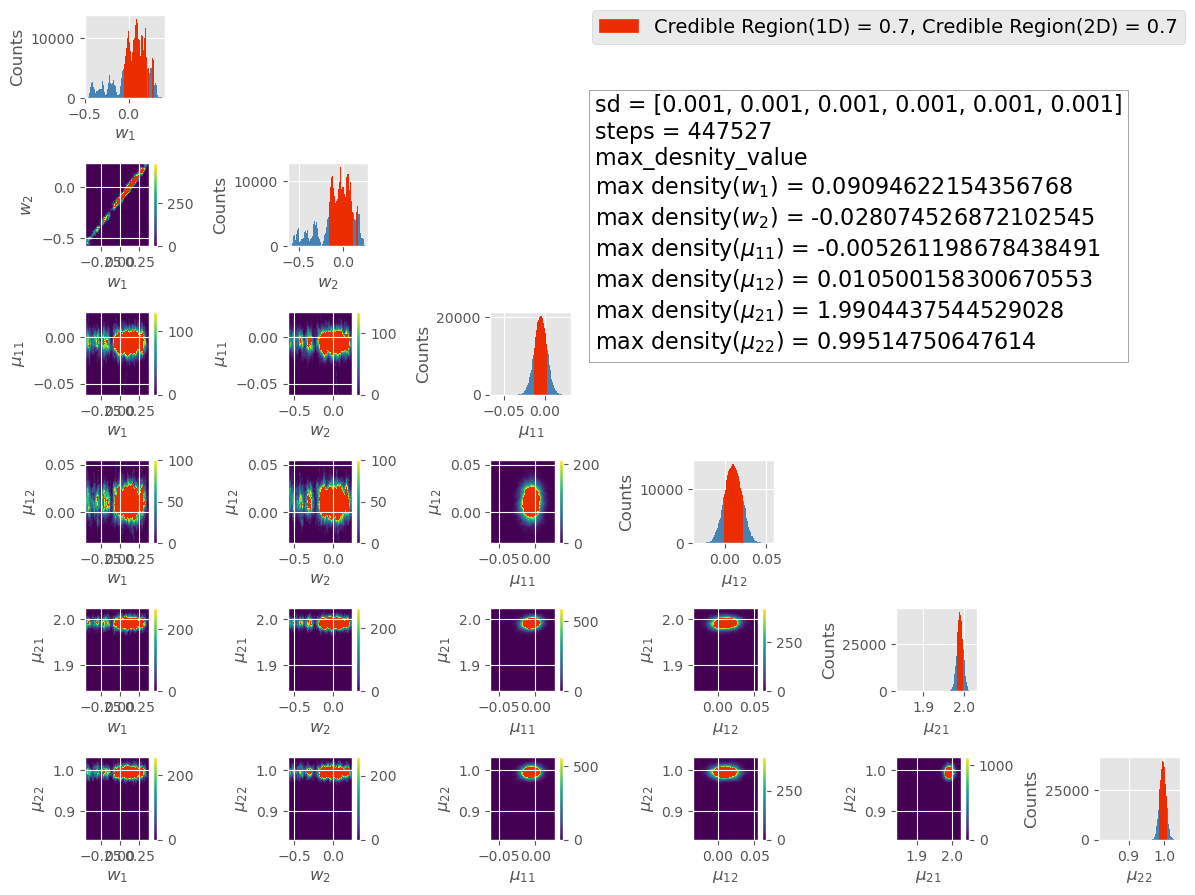

C:\Users\91464\AppData\Local\Temp\ipykernel_17556\2698483527.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


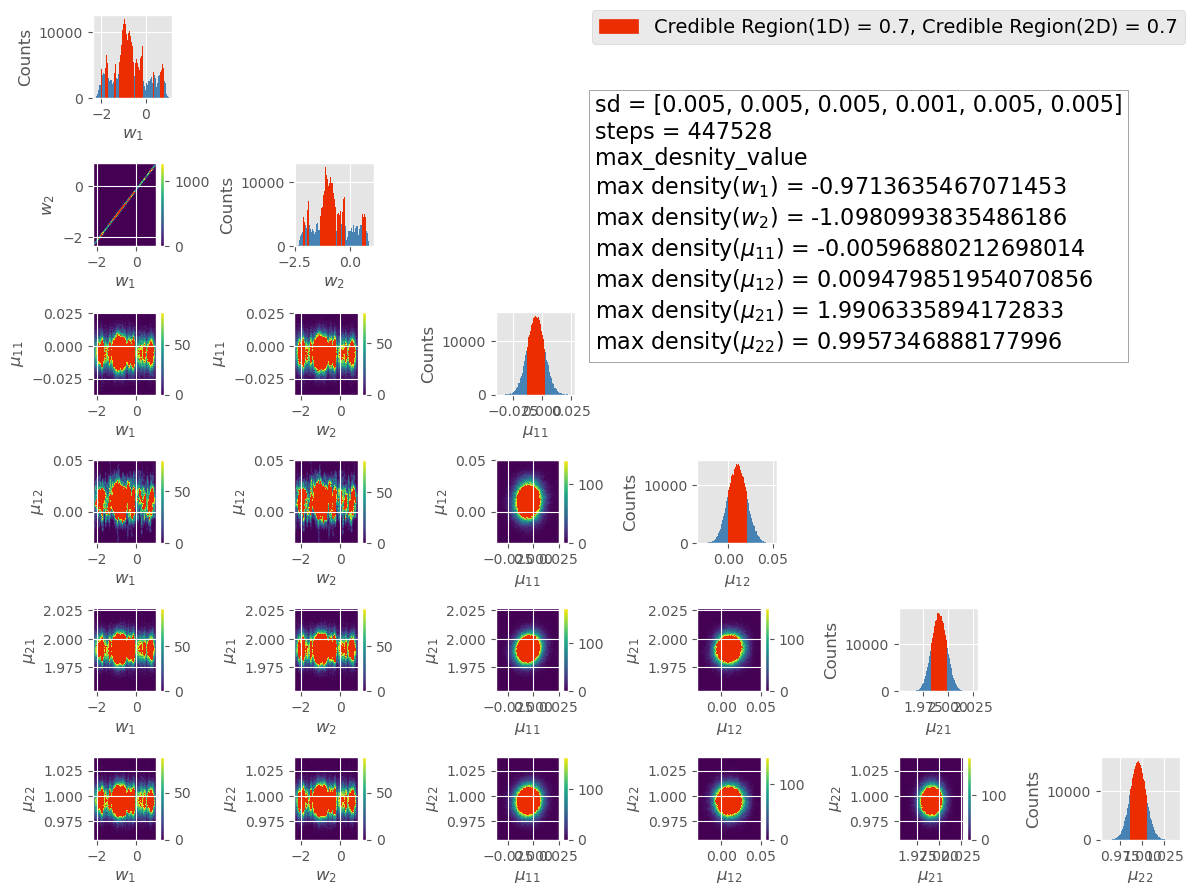

C:\Users\91464\AppData\Local\Temp\ipykernel_17556\2698483527.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


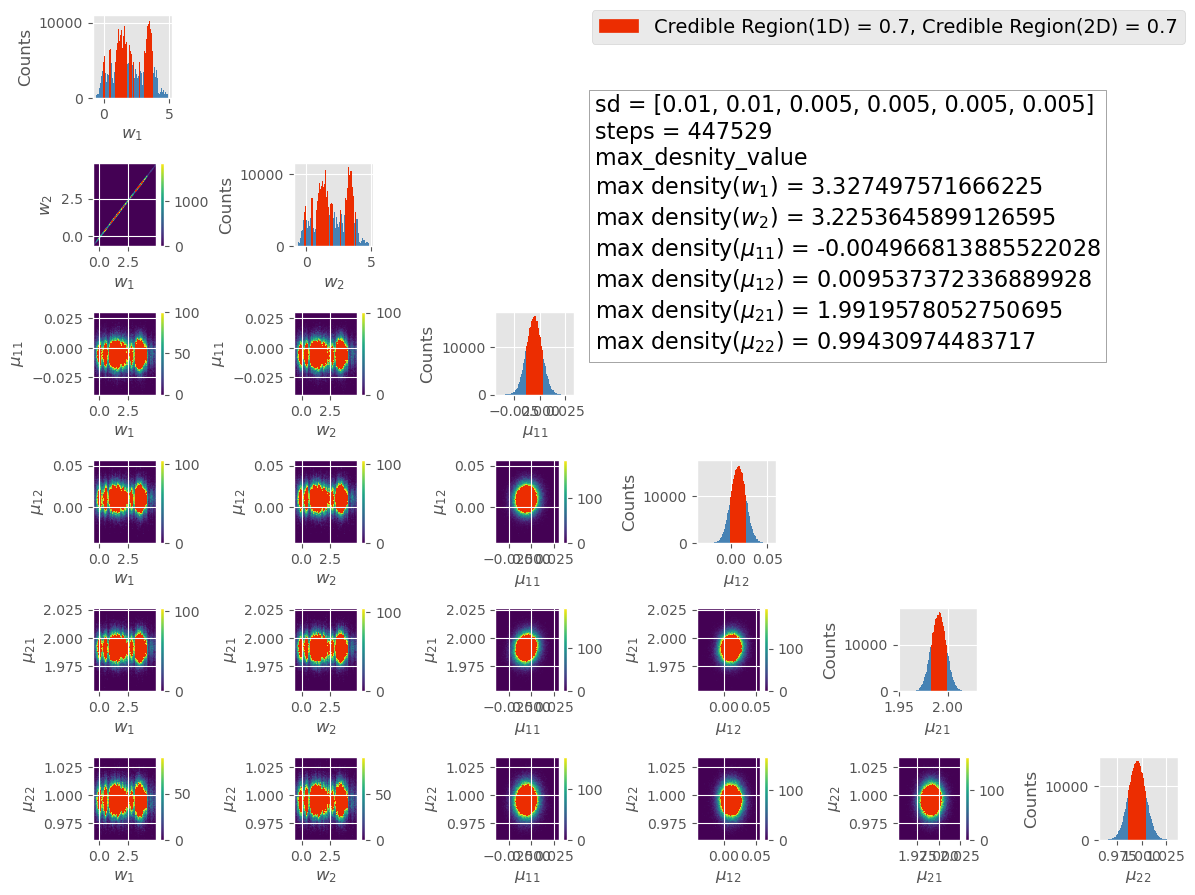

In [65]:
for Res_G_SF in Res:
    sd = Res_G_SF["PD_sd"]
    steps = Res_G_SF["Thetas"].shape[0]
    _ = density_plots(
        Res_G_SF["Thetas"],
        plot_axis=[0, 1, 2, 3, 4, 5],
        bins=100,
        burn_in=5000,
        axis_name=["$w_1$", "$w_2$", "$\mu_{11}$", "$\mu_{12}$", "$\mu_{21}$", "$\mu_{22}$"],
        cr_1D=0.7,
        cr_2D=0.7,
        information=f"sd = {sd}\nsteps = {steps}",
        Saving_address=f"./Implementation_Images/GMM2D/MHMCMC/density_plots sd={sd}.png"
    )


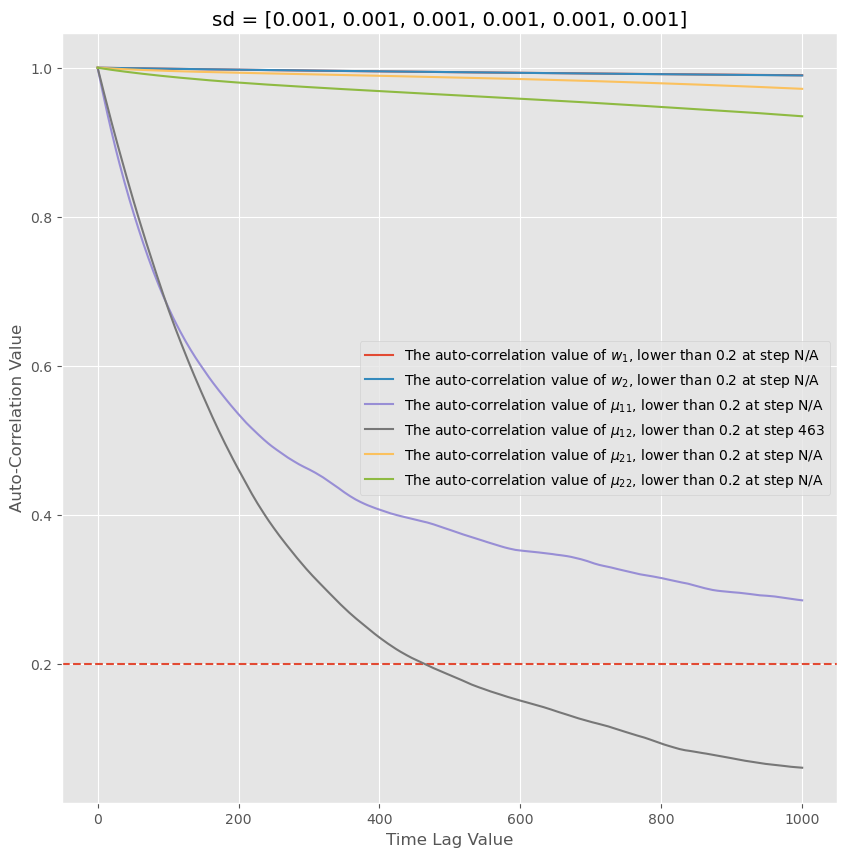

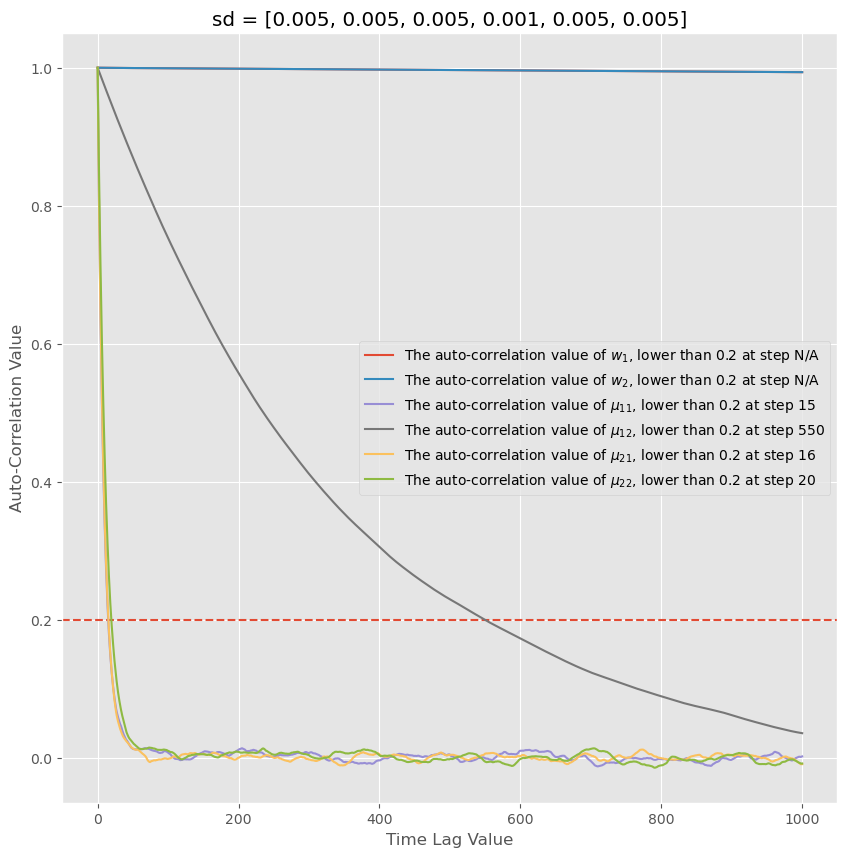

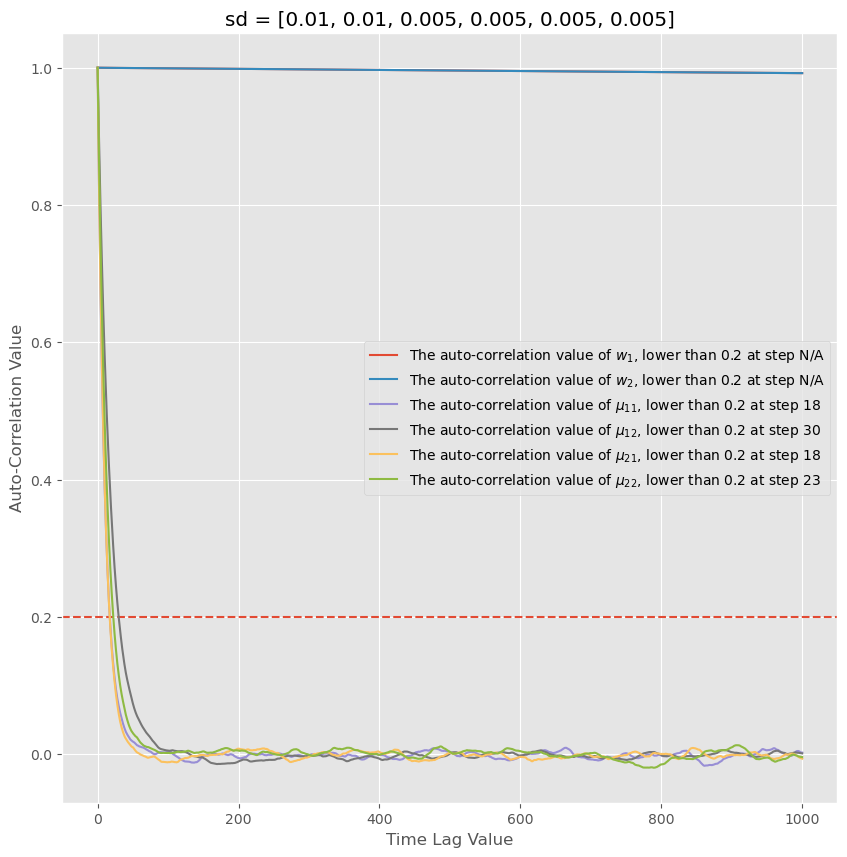

In [24]:
for Res_G_SF in Res:
    sd = Res_G_SF["PD_sd"]
    Vts.auto_corr_plot(Thetas=Res_G_SF["Thetas"], plot_nth_theta=[0,1,2,3,4,5], theta_index=["$w_1$", "$w_2$", "$\mu_{11}$", "$\mu_{12}$", "$\mu_{21}$", "$\mu_{22}$"], max_time_lag=1000, data_range=[1000, steps], Threshold=0.2, set_title=f"sd = {sd}")

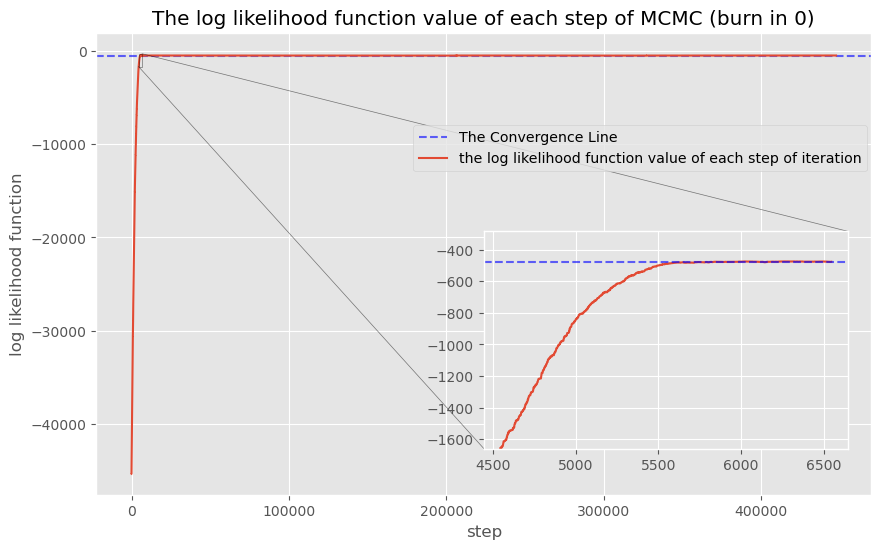

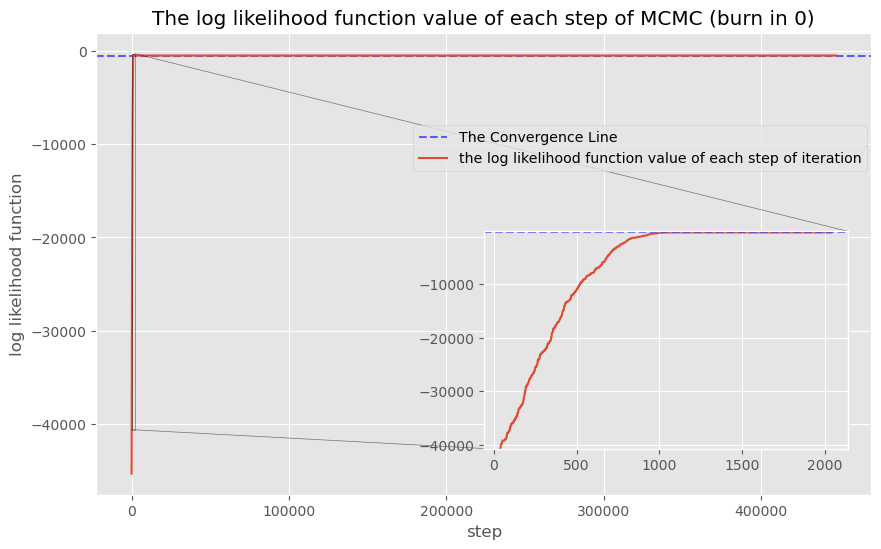

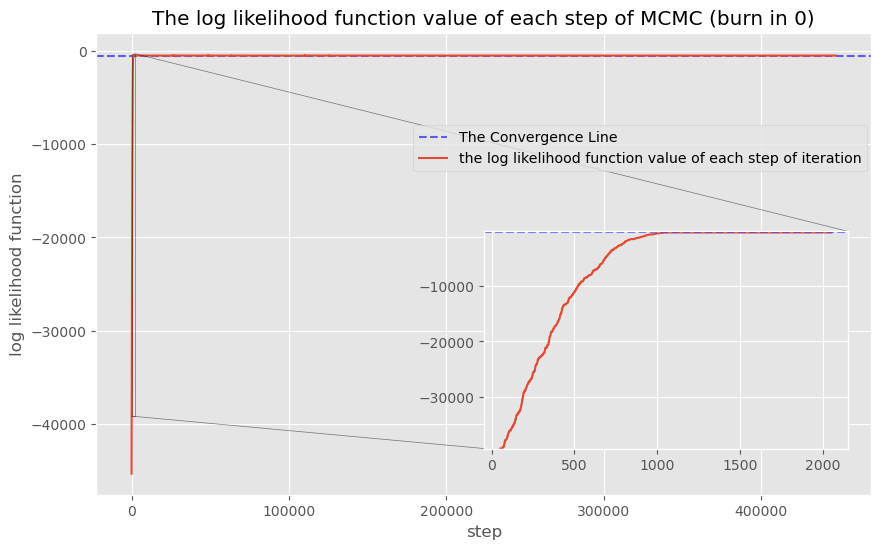

In [68]:
for Res_i in Res:
    sd = Res_i["PD_sd"]
    Vts.targetDis_step_plot(
        Thetas=Res_i["Thetas"], 
        rho=L_Gen.Log_Likelihood, 
        target_type="log likelihood function", 
        burn_in=0, 
        figsize=(10,6),
        Saving_address=f"./Implementation_Images/GMM2D/MHMCMC/likelihood_plot sd={sd}.png",
        zoom_size=1000
    )

In [66]:
for Res_G_SF in Res:
    sd = Res_G_SF["PD_sd"]
    ac = Res_G_SF["Acceptance_Rate"]
    time = Res_G_SF["Run_Times"][-1]
    print(f"When sd = {sd}, acceptance rate = {ac}, time taken {time}")

When sd = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001], acceptance rate = 0.9018470435237282, time taken 1199.8846064
When sd = [0.005, 0.005, 0.005, 0.001, 0.005, 0.005], acceptance rate = 0.5968265601851955, time taken 1123.0516607
When sd = [0.01, 0.01, 0.005, 0.005, 0.005, 0.005], acceptance rate = 0.5181307091399868, time taken 1127.7333614


## Hamiltonian MCMC

### Initializing the list to collect the outputs of the MCMC algorithm

In [42]:
Res_H = []

In [43]:
# Loading the pre outputs
data_folder = "Datas/Data_40bins_100000scale_GMM_H/"
for name in os.listdir(data_folder):
    data_dir = os.path.join(data_folder, name)
    Res_H.append(Sts.Loading_Data(data_dir))

### Applying MCMC algorithm on the likelihood funciton

In [44]:
steps = 1000000

In [70]:
# for epsilon in [0.004, 0.005, 0.006]:
L = 8
epsilon = 0.002
Prop_H = PDs.HamiltonianProposalFunction(rho=L_Gen.Log_Likelihood, epsilon=epsilon, L=L, log_likelihood=True)
MHMC_SF = MHMC(rho=Prop_H.U, log_likelihood=True)
Res_H_i = MHMC_SF.generate(
    theta0=[0 for _ in range(6)],
    ProposalFunction=Prop_H,
    steps=steps,
    OutputRunTime=100,
    MaxTime=1200
)
Res_H.append(Res_H_i)

In [73]:
for k in range(len(Res_H)):
    epsilon = Res_H[k]["PF_epsilon"]
    L = Res_H[k]["PF_L"]
    Saving_dir = f"Datas/Data_40bins_100000scale_GMM_H/Res_G_SF(epsilon={epsilon}, L={L}).npz"
    Sts.Saving_Data(Res_H[k], FileName=Saving_dir)

In [38]:
# for Res_i in Res_H:
#     epsilon = Res_i["PF_epsilon"]
#     L = Res_i["PF_L"]
#     Vts.density_plot(
#         Res_i["Thetas"], 
#         bins=50,
#         burn_in=10000,
#         credible_region=0,
#         x_name="B",
#         y_name="C",
#         label = f" with L = {L}, $\epsilon$ = {epsilon}",
#         alpha=1,
#     )

C:\Users\91464\AppData\Local\Temp\ipykernel_17556\2698483527.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


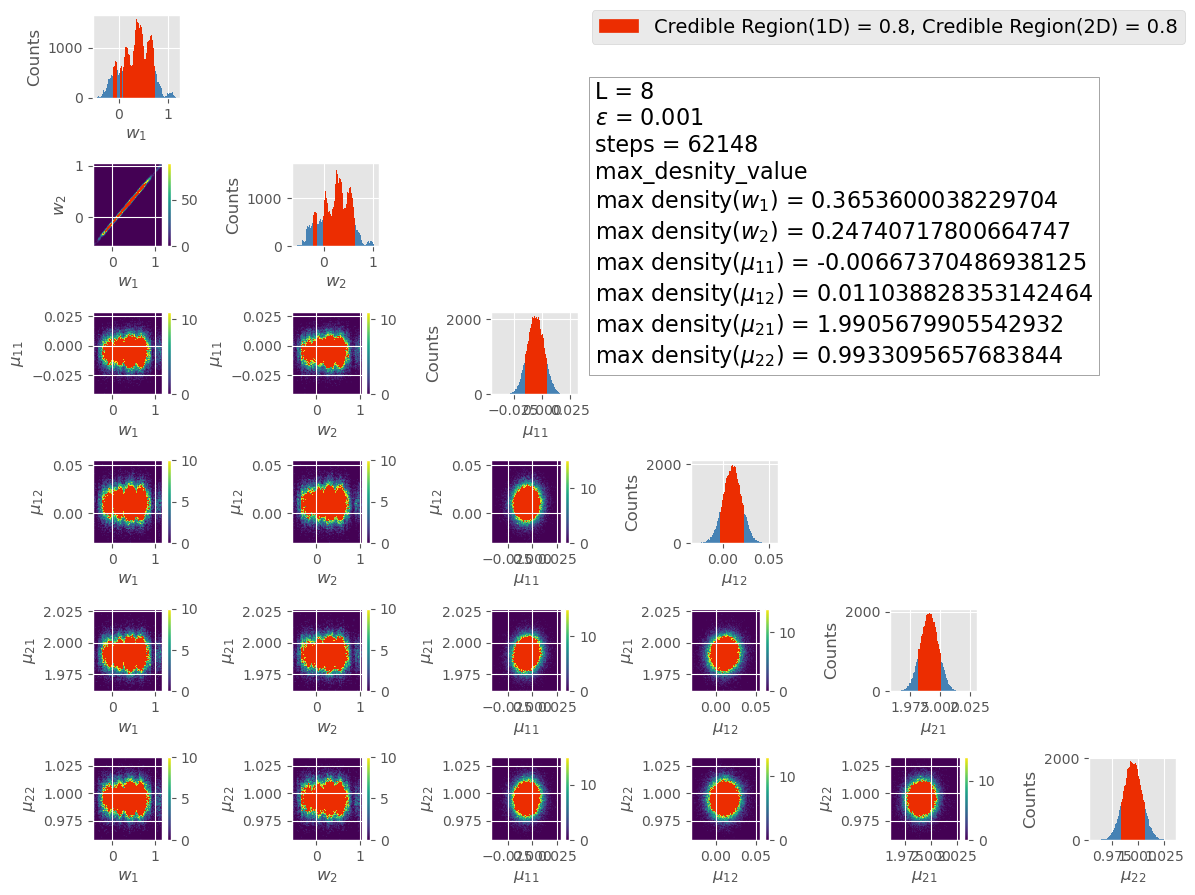

C:\Users\91464\AppData\Local\Temp\ipykernel_17556\2698483527.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


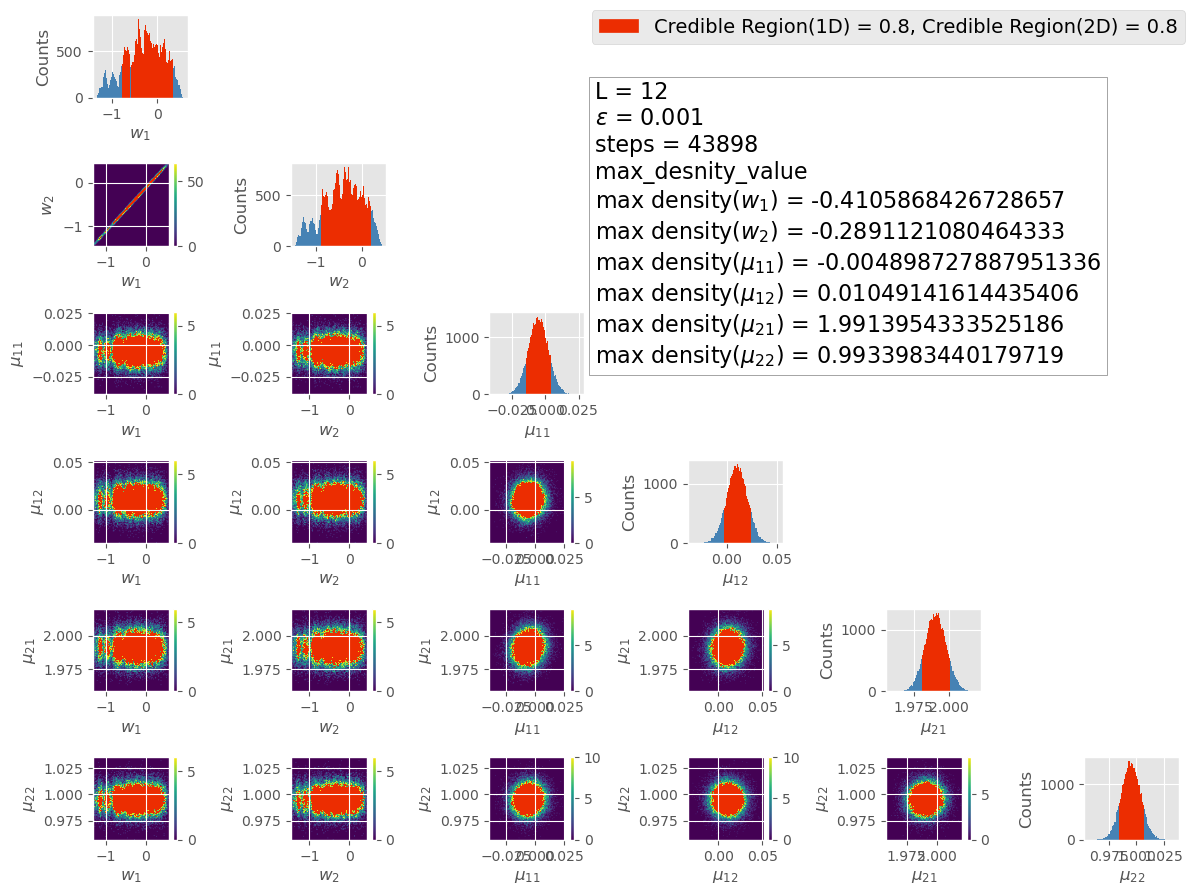

C:\Users\91464\AppData\Local\Temp\ipykernel_17556\2698483527.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


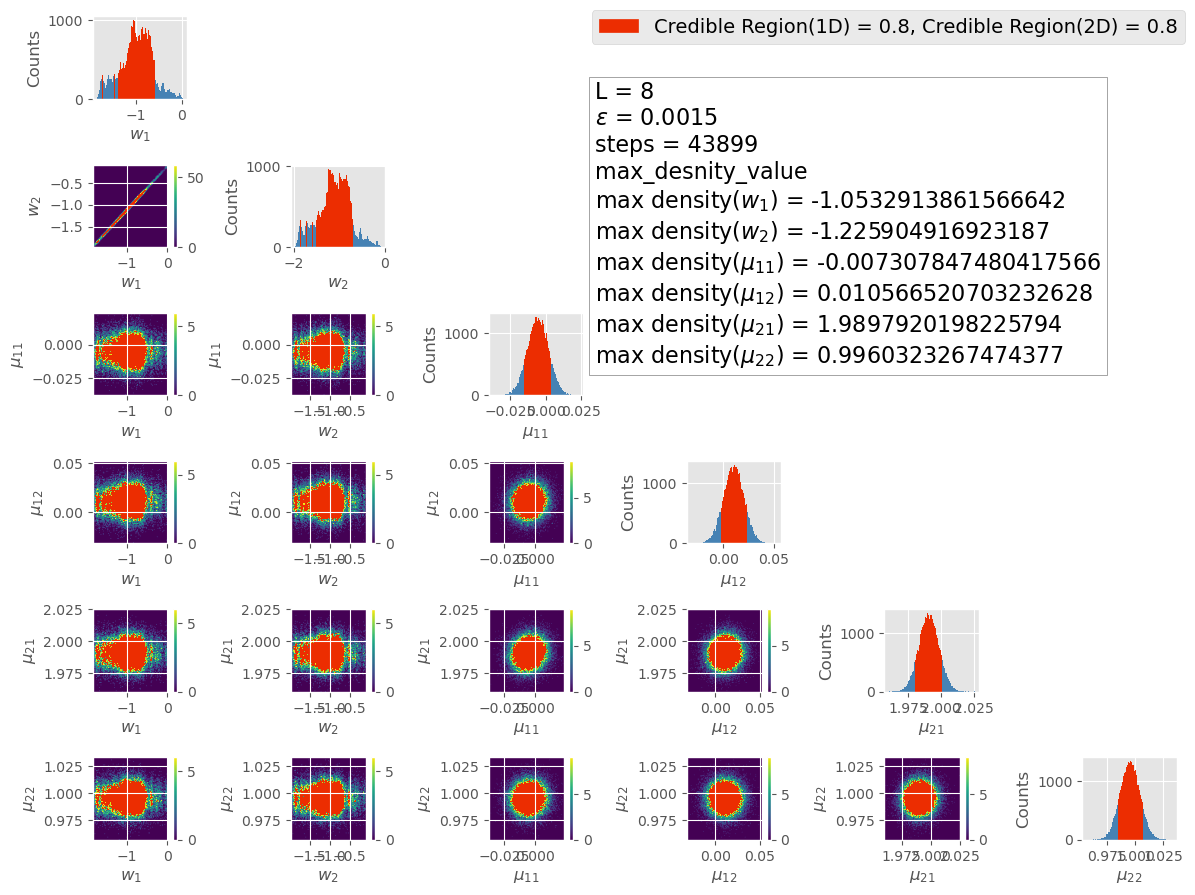

C:\Users\91464\AppData\Local\Temp\ipykernel_17556\2698483527.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


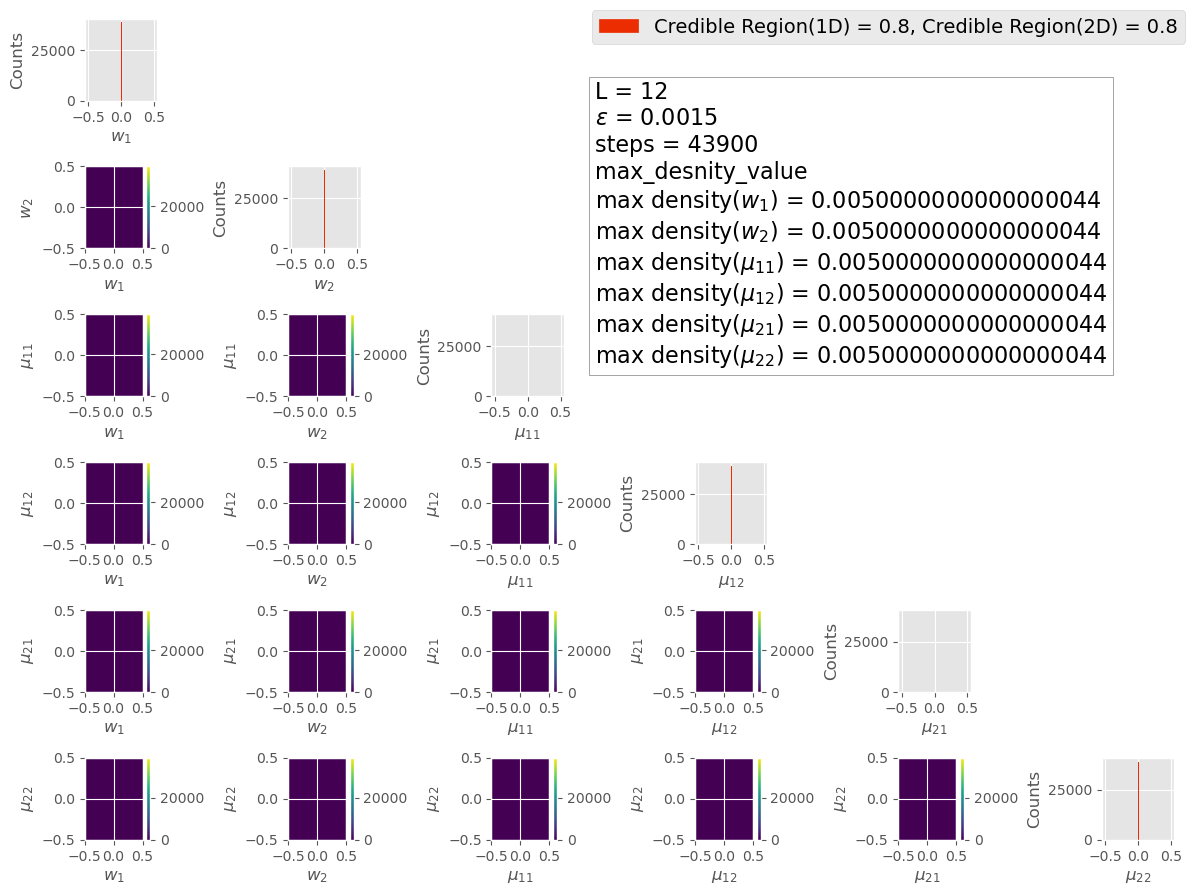

C:\Users\91464\AppData\Local\Temp\ipykernel_17556\2698483527.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


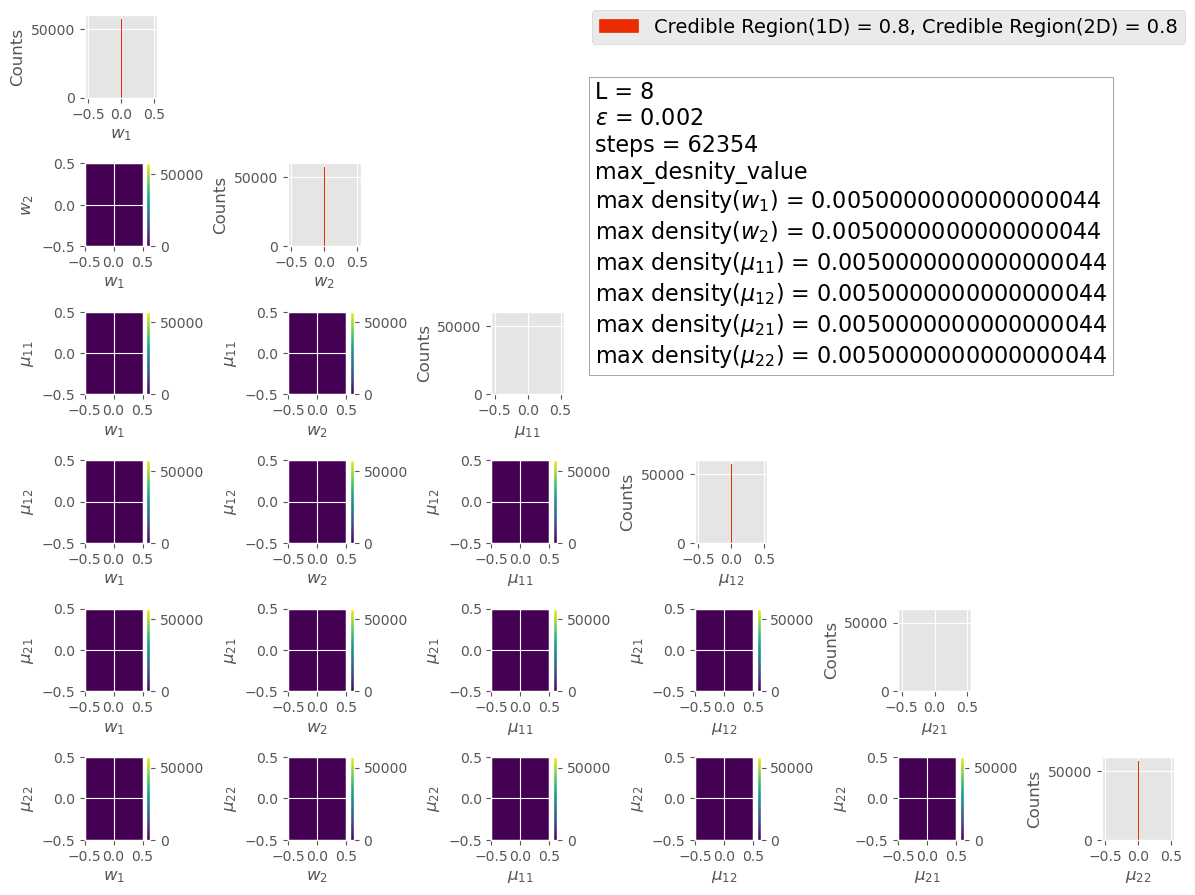

In [71]:
for Res_H_i in Res_H:
    steps = Res_H_i["Thetas"].shape[0]
    epsilon = Res_H_i["PF_epsilon"]
    L = Res_H_i["PF_L"]
    _ = density_plots(
        Res_H_i["Thetas"],
        plot_axis=[0, 1, 2, 3, 4, 5],
        bins=100,
        burn_in=5000,
        axis_name=["$w_1$", "$w_2$", "$\mu_{11}$", "$\mu_{12}$", "$\mu_{21}$", "$\mu_{22}$"],
        cr_1D=0.8,
        cr_2D=0.8,
        information=f"L = {L}\n$\epsilon$ = {epsilon}\nsteps = {steps}",
        Saving_address=f"./Implementation_Images/GMM2D/HMCMC/density_plots epsilon={epsilon}, L={L}.png"
    )


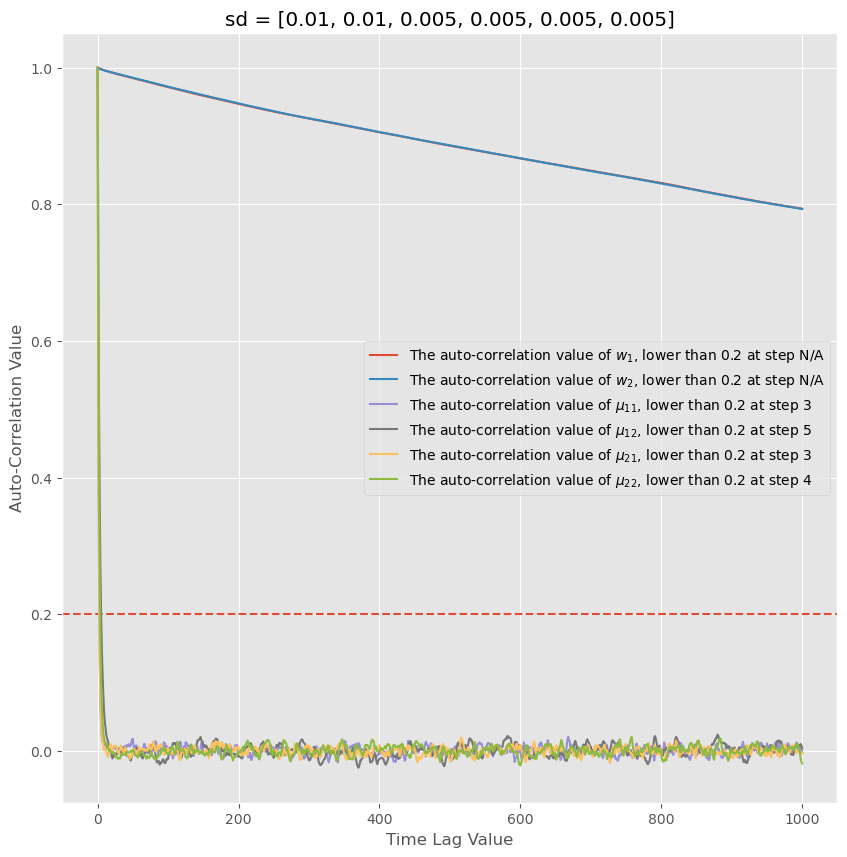

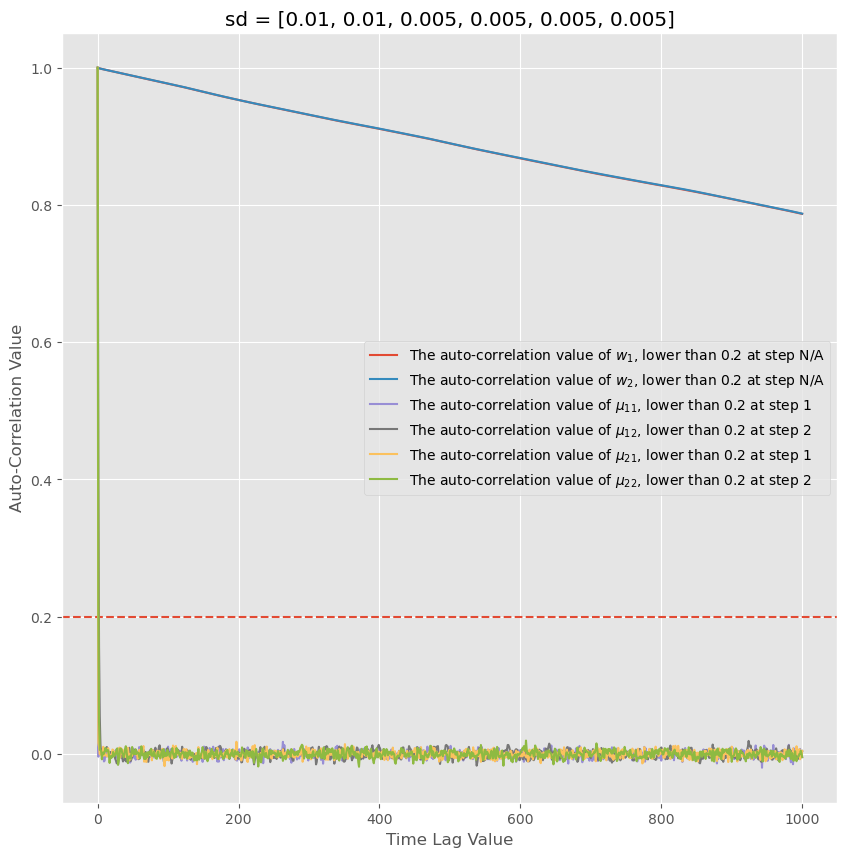

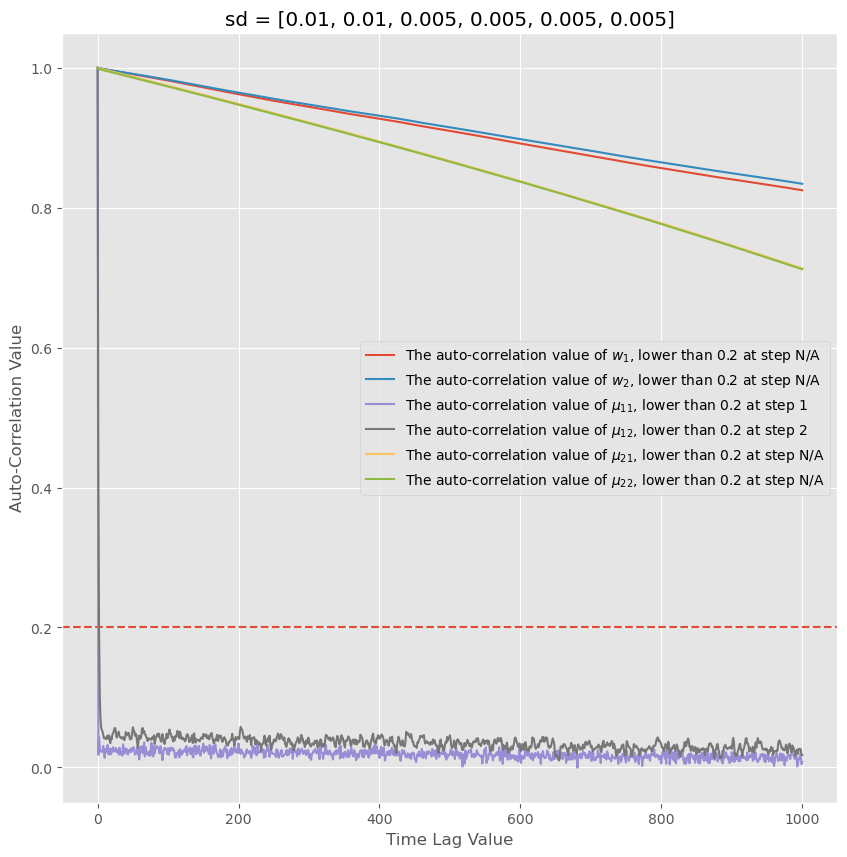

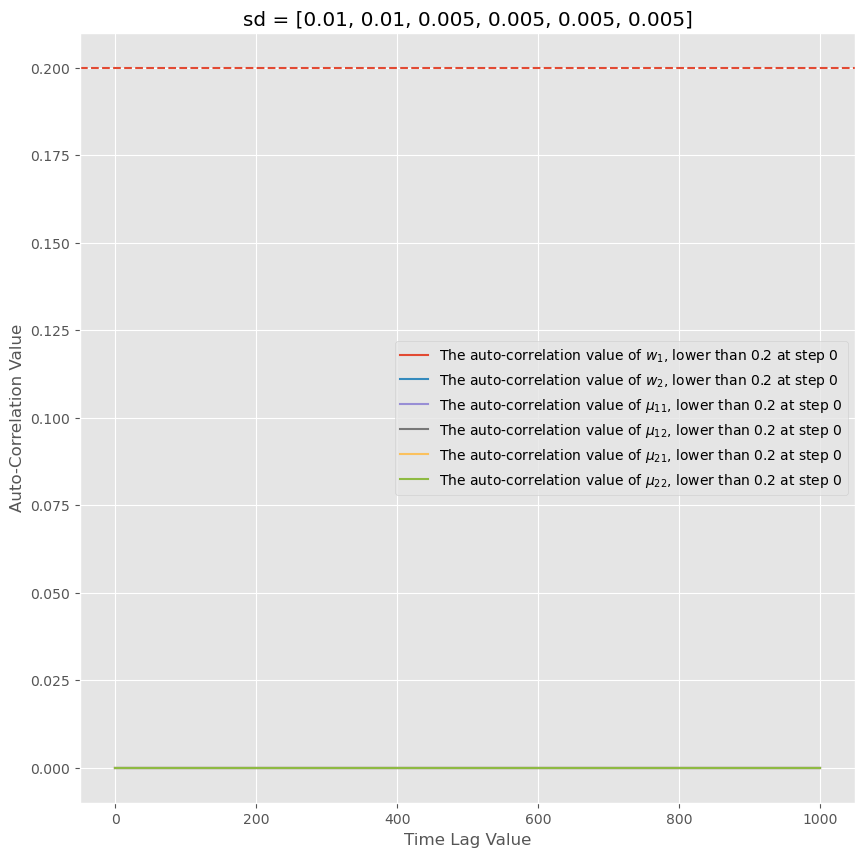

In [63]:
for Res_i in Res_H:
    epsilon = Res_i["PF_epsilon"]
    L = Res_i["PF_L"]
    Vts.auto_corr_plot(Thetas=Res_i["Thetas"], plot_nth_theta=[0,1,2,3,4,5], theta_index=["$w_1$", "$w_2$", "$\mu_{11}$", "$\mu_{12}$", "$\mu_{21}$", "$\mu_{22}$"], max_time_lag=1000, data_range=[1000, steps], Threshold=0.2, set_title=f"sd = {sd}",
        Saving_address=f"./Implementation_Images/GMM2D/HMCMC/auto_correlation_plot epsilon={epsilon}, L={L}.png"
    )

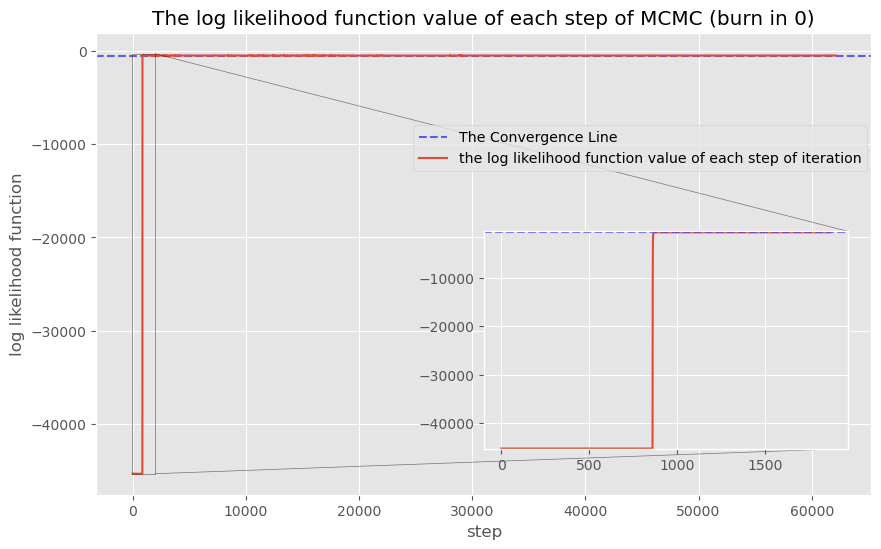

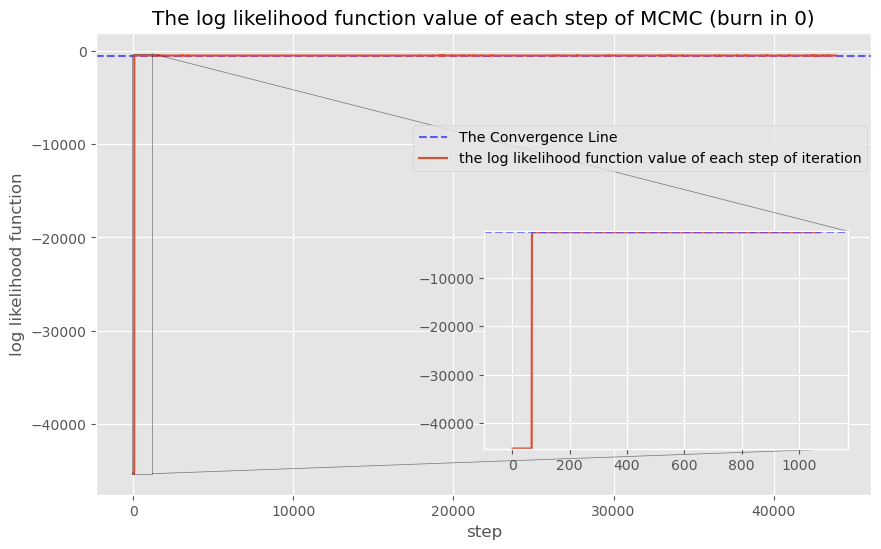

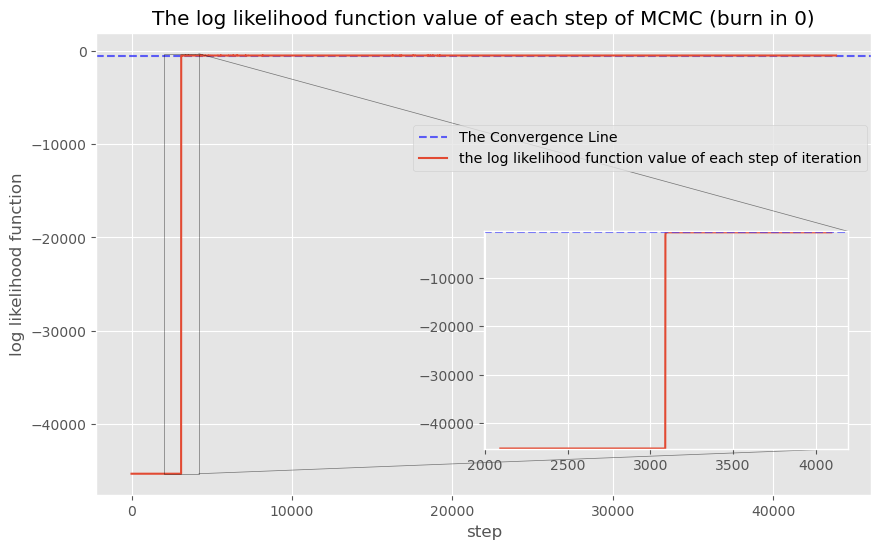

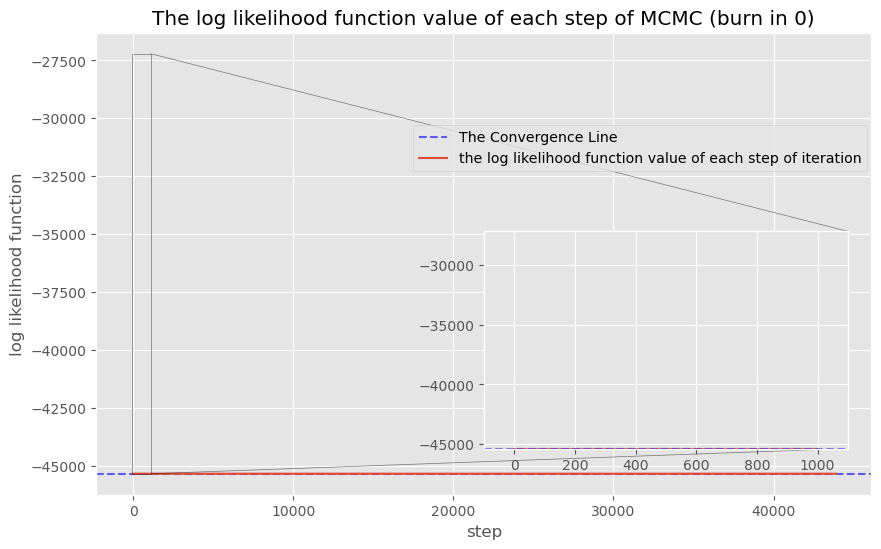

In [64]:
for Res_H_i in Res_H:
    epsilon = Res_H_i["PF_epsilon"]
    L = Res_H_i["PF_L"]
    Vts.targetDis_step_plot(
        Thetas=Res_H_i["Thetas"], 
        rho=L_Gen.Log_Likelihood, 
        target_type="log likelihood function", 
        burn_in=0, 
        figsize=(10,6),
        zoom_size=1000,
        Saving_address=f"./Implementation_Images/GMM2D/HMCMC/likelihood_plot epsilon={epsilon}, L={L}.png"
    )

In [67]:
for Res_i in Res_H:
    L = Res_i["PF_L"]
    epsilon = Res_i["PF_epsilon"]
    ac = Res_i["Acceptance_Rate"]
    time = Res_i["Run_Times"][-1]
    print(f"When L = {L}, $\epsilon$ = {epsilon}, acceptance rate = {ac}, time taken {time}")

When L = 8, $\epsilon$ = 0.001, acceptance rate = 0.9837482098894557, time taken 1199.0594968000005
When L = 12, $\epsilon$ = 0.001, acceptance rate = 0.995671685992209, time taken 1197.3455815000016
When L = 8, $\epsilon$ = 0.0015, acceptance rate = 0.9238234088113354, time taken 832.9787617999973
When L = 12, $\epsilon$ = 0.0015, acceptance rate = 0.0, time taken 1197.1504096999997
